# Beam creation example

This notebook creates Fig 4. from the paper "Focused beam propagation in cholesteric liquid crystals".
The method is explained in the paper.


In [1]:
# Requisities

#: library configuration 
from dtmm2.conf import FDTYPE, CDTYPE

#: transfer matrices
import dtmm2.tmm as tmm

#: planewave functions
from dtmm2 import wave

#: matrix multiplication functions
from dtmm2.linalg import dotmv

#: modal decomposition 
from dtmm2.field import field2modes, modes2field

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


## Jones vector representation

We start by defining the Jones vector representation of the field. We write a tilted beam with a Gaussian beam profile in the reference space and define a periodic phase to set the propagation direction. 

### Modal mask

First, we define a modal mask, that is, we determine which of the eigenmodes in the reciprocal space are valid. The mask operates in the reciprocal space and in reciprocal space coordinates, so we use fftshift function to visualize the mask. The mask depends on the domain size, pixel size and the wavelength and the numerical aperture (NA) of the lens that is being used to focus the beam (or the $\beta_{max}$) parameter

Number of modes: 1793


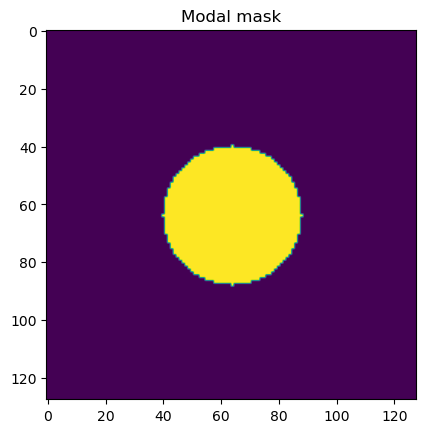

In [2]:
#: shape
SHAPE = (128,128)

#: domain size in um
SIZE = (8,8) 

#: pixel size in nm
PIXELSIZE = SIZE[0]*1000/SHAPE[0]

PIXELSIZE_J = SIZE[1]*1000/SHAPE[1]

#: instead of PIXELSIZE_J, we use pixel aspect ratio in the method
PIXEL_ASPECT = PIXELSIZE_J / PIXELSIZE

#: objective lens focal length in mm
FOCAL = 5 

#: wavelength in nm
WAVELENGTH = 500

#: wave number in pixel units
K0 = wave.k0(WAVELENGTH,PIXELSIZE)

KPIXELSIZE = FOCAL * WAVELENGTH / SIZE[0] #wavelength in nm, size in um, focal in mm, result in um

KPIXELSIZE_J = KPIXELSIZE *SIZE[0] / SIZE[1]

KPIXEL_ASPECT = KPIXELSIZE_J / KPIXELSIZE

KSIZE = (KPIXELSIZE*SHAPE[0], KPIXELSIZE_J*SHAPE[1])

#: NA of the objective lens. Sould be lower than 1, except if we use liquid-immersion objectives.
NA = 1.5

mask = wave.eigenmask(SHAPE,K0, betamax = NA, aspect = PIXEL_ASPECT)

IMAGE_ASPECT = SHAPE[1]/SHAPE[0]*SIZE[0]/SIZE[1]
KIMAGE_ASPECT = SHAPE[1]/SHAPE[0]*KSIZE[0]/KSIZE[1]

def set_ticks(ax, size = SIZE, units = "$\mu$m"):
    NTICKS = 5
    
    xt = np.linspace(-0.5, 2*(SHAPE[1]//2)+0.5, NTICKS)
    xl = np.linspace(-size[1]/2,size[1]/2,NTICKS)
    xl = [f"{x:.1f}" for x in xl]
    
    ax.set_xticks(xt)
    ax.set_yticks(xt)
    ax.set_xticklabels(xl)
    ax.set_yticklabels(xl)
    ax.set_xlabel("$x$ " + f"[{units}]")
    ax.set_ylabel("$y$ " + f"[{units}]")
    ax.grid()

plt.figure()

plt.imshow(np.fft.fftshift(mask),aspect = KIMAGE_ASPECT)
plt.title("Modal mask")

print("Number of modes:",mask.sum())

### Beam creation

Now, we build a gaussian beam propagating at oblique incidence using the jones vector representation.

We start by writing a gasussian beam in the reference, infinity space. Next, we compute the beam in the reciprocal plane and apply modal filtering. We then use the filtered field defined in the reciprocal plane to construct a true Jones vector representation of a confined beam.

Text(0.5, 1.0, 'Filtered beam')

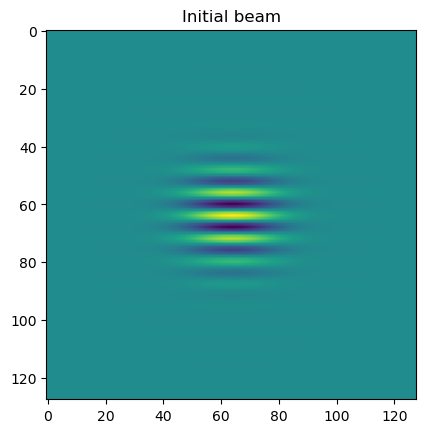

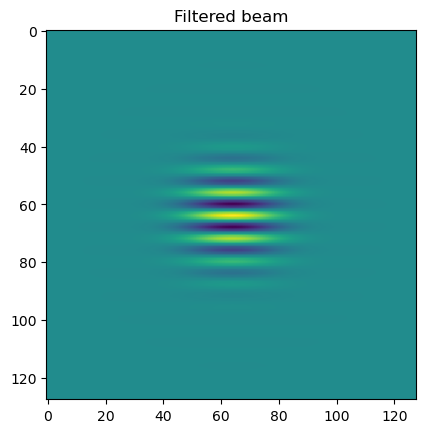

In [6]:
#: waist size in um
WAIST = 1 

#: objective lens focal length in mm
FOCAL = 5 

#: Fourier plane pixel size in mm
FOURIER_PIXELSIZE = FOCAL*WAVELENGTH/PIXELSIZE/SHAPE[0] 

FOURIER_PIXELSIZE_J = FOCAL*WAVELENGTH/PIXELSIZE_J/SHAPE[1] 

#: Fourier plane size in mm
FOURIER_SIZE = FOURIER_PIXELSIZE * SHAPE[0], FOURIER_PIXELSIZE_J * SHAPE[1] 

#: mode selection indices.
KI = 16
KJ = 0

K0 = wave.k0(WAVELENGTH,PIXELSIZE)

def gaussian_window(x,y, waist = WAIST, center = (0.,0.)):
    return np.asarray(np.exp(-((x-center[0])**2+(y-center[1])**2)/waist**2),CDTYPE)

yw = np.fft.fftfreq(SHAPE[0],d = 1/SHAPE[0])*PIXELSIZE/1000
xw = np.fft.fftfreq(SHAPE[1],d = 1/SHAPE[1])*PIXELSIZE_J/1000

#we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
yy,xx = np.meshgrid(yw,xw, indexing = 'ij')

amplitude = gaussian_window(xx,yy)
phase = wave.eigenwave(SHAPE,KI,KJ)

#: initial beam in the reference space
beam = amplitude * phase

plt.figure()
plt.imshow(np.fft.fftshift(beam.real))
plt.title("Initial beam")

#: beam in the Fourier plane
fbeam = 1j*np.fft.ifft2(beam, norm = "ortho")

#: apply modal mask filter
fbeam[np.logical_not(mask)] = 0

#: reconstruct the beam
beam = -1j*np.fft.fft2(fbeam, norm = "ortho")

#: set this to None, we use this in imshow to display black color
fbeam[np.logical_not(mask)] = np.nan

#: the amplitude in fourier plane 
fbeam *= SIZE[0]/(FOURIER_SIZE[0]*1000)

# the Jones vector representation
jones = np.zeros(shape = (4,) + beam.shape, dtype = beam.dtype)
jones[0] = beam # x polarized

plt.figure()
plt.imshow(np.fft.fftshift(beam.real))
plt.title("Filtered beam")

### Electromagnetic field visualization - Berreman vector

Here, we compute the Berreman vector representation of the beam from the Jones vector representation. We plot the real part of the field to inspect the field amplitude and phase

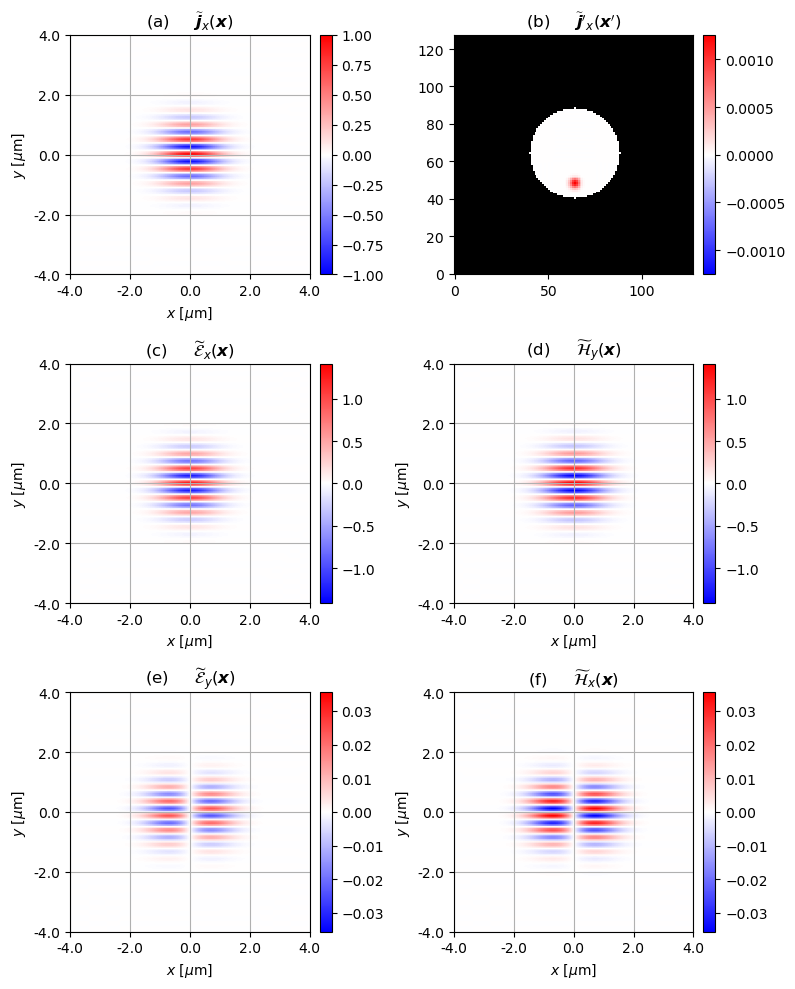

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

FIGSIZE = (8,10)

def set_ticks(ax, size = SIZE, units = "$\mu$m"):
    NTICKS = 5
    
    xt = np.linspace(-0.5, 2*(SHAPE[1]//2)+0.5, NTICKS)
    xl = np.linspace(-size[1]/2,size[1]/2,NTICKS)
    xl = [f"{x:.1f}" for x in xl]

    yt = np.linspace(-0.5, 2*(SHAPE[0]//2)+0.5, NTICKS)
    yl = np.linspace(-size[0]/2,size[0]/2,NTICKS)
    yl = [f"{x:.1f}" for x in yl]
    
    ax.set_xticks(xt)
    ax.set_yticks(yt)
    ax.set_xticklabels(xl)
    ax.set_yticklabels(yl)
    ax.set_xlabel("$x$ " + f"[{units}]")
    ax.set_ylabel("$y$ " + f"[{units}]")
    ax.grid()

def add_colorbar(fig,im,ax, pad = 0.1, pack_start = False):
    # add color bar below chart
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size = '5%', pad = pad ,pack_start = pack_start)
    fig.add_axes(cax)
    
    fig.colorbar(im, cax = cax, orientation = 'vertical')
    


fig,axs = plt.subplots(3,2, figsize = FIGSIZE)
tmm.modal_beam_mat(K0, epsilon = 1.5**2, mask = mask, aspect = KIMAGE_ASPECT)
vmax = fbeam[mask].imag.max()
vmin = -vmax

cmap = mpl.colormaps.get_cmap('bwr')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ax = axs[0,1]
im = ax.imshow(np.fft.fftshift(fbeam).imag, aspect = KIMAGE_ASPECT,
               cmap = cmap, origin = "lower", vmin = vmin, vmax = vmax, interpolation = "nearest")
add_colorbar(fig,im,ax)
ax.set_title("(b)\t"+r"$\widetilde{\boldsymbol{j}}'_x(\boldsymbol{x}')$")
#set_ticks(ax, size = FOURIER_SIZE, units = "mm")

vmax = 1
vmin = -vmax

ax = axs[0,0]
im = ax.imshow(np.fft.fftshift(jones[0].real), aspect = IMAGE_ASPECT,
               origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
add_colorbar(fig,im,ax)
ax.set_title("(a)\t"+r"$\widetilde{\boldsymbol{j}}_x(\boldsymbol{x})$")
set_ticks(ax)

bmat = tmm.modal_beam_mat(K0, epsilon = 1.5**2, mask = mask, aspect = KIMAGE_ASPECT)
mask, modes = field2modes(jones, k0 = K0, mask = mask)
modes = dotmv(bmat, modes)

field = modes2field(mask,modes)

vmax = vmax*np.sqrt(2)
vmin = -vmax

ax = axs[1,0]
im = ax.imshow(np.fft.fftshift(field[0].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
add_colorbar(fig,im,ax)
ax.set_title("(c)\t"+r"$\widetilde{\mathcal{E}}_x(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[1,1]
im = ax.imshow(np.fft.fftshift(field[1].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(d)\t"+r"$\widetilde{\mathcal{H}}_y(\boldsymbol{x})$")
set_ticks(ax)

vmax = max(field[2].real.max(),field[3].real.max())
vmin = -vmax

ax = axs[2,0]
im = ax.imshow(np.fft.fftshift(field[2].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$\widetilde{\mathcal{E}}_y(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[2,1]
im = ax.imshow(np.fft.fftshift(field[3].real), aspect = 1/PIXEL_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$\widetilde{\mathcal{H}}_x(\boldsymbol{x})$")
set_ticks(ax)

plt.tight_layout()
#plt.savefig("beam_creation.pdf")

### Electromagnetic field visualization - Full field vector

Same as before, but here we compute the full field vector, which allows us to plot also the z components of the E and H fields. Note that the example shown below was computed for normal incidence.

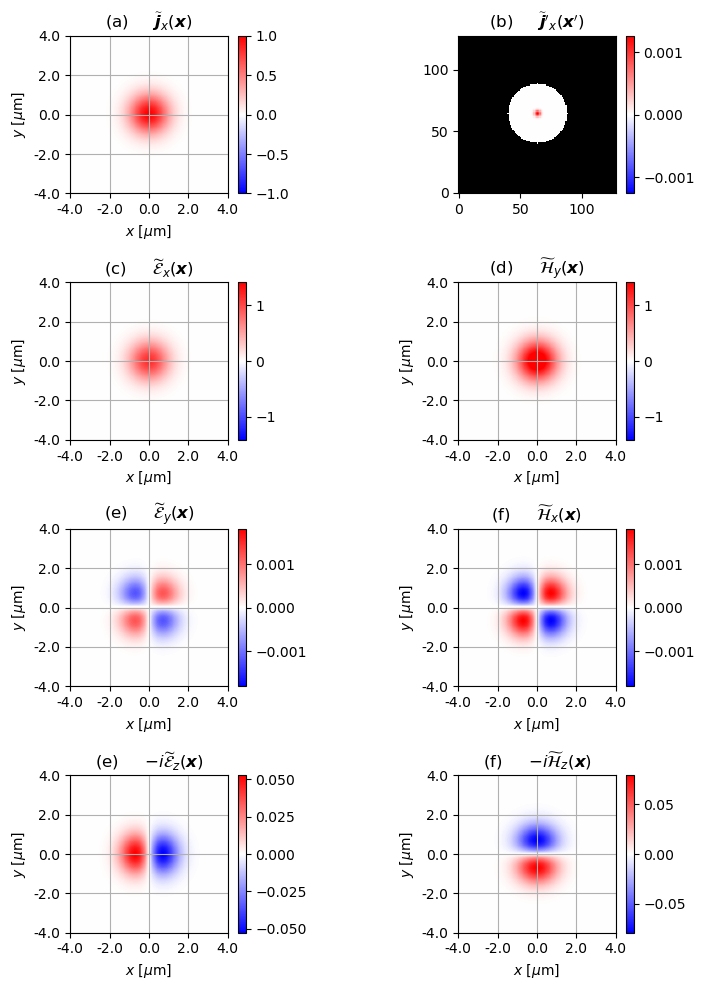

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

FIGSIZE = (8,10)

def set_ticks(ax, size = SIZE, units = "$\mu$m"):
    NTICKS = 5
    
    xt = np.linspace(-0.5, 2*(SHAPE[1]//2)+0.5, NTICKS)
    xl = np.linspace(-size[1]/2,size[1]/2,NTICKS)
    xl = [f"{x:.1f}" for x in xl]

    yt = np.linspace(-0.5, 2*(SHAPE[0]//2)+0.5, NTICKS)
    yl = np.linspace(-size[0]/2,size[0]/2,NTICKS)
    yl = [f"{x:.1f}" for x in yl]
    
    ax.set_xticks(xt)
    ax.set_yticks(yt)
    ax.set_xticklabels(xl)
    ax.set_yticklabels(yl)
    ax.set_xlabel("$x$ " + f"[{units}]")
    ax.set_ylabel("$y$ " + f"[{units}]")
    ax.grid()

def add_colorbar(fig,im,ax, pad = 0.1, pack_start = False):
    # add color bar below chart
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size = '5%', pad = pad ,pack_start = pack_start)
    fig.add_axes(cax)
    
    fig.colorbar(im, cax = cax, orientation = 'vertical')
    


fig,axs = plt.subplots(4,2, figsize = FIGSIZE)

vmax = fbeam[mask].imag.max()
vmin = -vmax

cmap = mpl.colormaps.get_cmap('bwr')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ax = axs[0,1]
im = ax.imshow(np.fft.fftshift(fbeam).imag, aspect = KIMAGE_ASPECT,
               cmap = cmap, origin = "lower", vmin = vmin, vmax = vmax, interpolation = "nearest")
add_colorbar(fig,im,ax)
ax.set_title("(b)\t"+r"$\widetilde{\boldsymbol{j}}'_x(\boldsymbol{x}')$")
#set_ticks(ax, size = FOURIER_SIZE, units = "mm")

vmax = 1
vmin = -vmax

ax = axs[0,0]
im = ax.imshow(np.fft.fftshift(jones[0].real), aspect = IMAGE_ASPECT,
               origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
add_colorbar(fig,im,ax)
ax.set_title("(a)\t"+r"$\widetilde{\boldsymbol{j}}_x(\boldsymbol{x})$")
set_ticks(ax)

bmat = tmm.modal_beam_mat(K0, epsilon = 1.5**2, mask = mask, aspect = KPIXEL_ASPECT, field = "f")
mask, modes = field2modes(jones, k0 = K0, mask = mask)
modes = dotmv(bmat, modes)

field = modes2field(mask,modes)

vmax = vmax*np.sqrt(2)
vmin = -vmax

ax = axs[1,0]
im = ax.imshow(np.fft.fftshift(field[1].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
add_colorbar(fig,im,ax)
ax.set_title("(c)\t"+r"$\widetilde{\mathcal{E}}_x(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[1,1]
im = ax.imshow(np.fft.fftshift(field[2].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(d)\t"+r"$\widetilde{\mathcal{H}}_y(\boldsymbol{x})$")
set_ticks(ax)

vmax = max(field[3].real.max(),field[4].real.max())
vmin = -vmax

ax = axs[2,0]
im = ax.imshow(np.fft.fftshift(field[3].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$\widetilde{\mathcal{E}}_y(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[2,1]
im = ax.imshow(np.fft.fftshift(field[4].real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$\widetilde{\mathcal{H}}_x(\boldsymbol{x})$")
set_ticks(ax)


vmax = max(field[5].imag.max(),field[5].imag.max())
vmin = -vmax

ax = axs[3,0]
im = ax.imshow(np.fft.fftshift((-1j*field[5]).real), aspect = IMAGE_ASPECT,
               origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$-i\widetilde{\mathcal{E}}_z(\boldsymbol{x})$")
set_ticks(ax)

vmax = max(field[0].imag.max(),field[0].imag.max())
vmin = -vmax

ax = axs[3,1]
im = ax.imshow(np.fft.fftshift((-1j*field[0]).real), aspect = IMAGE_ASPECT,
               origin = "lower",
               vmin = vmin, 
               vmax = vmax, 
               cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$-i\widetilde{\mathcal{H}}_z(\boldsymbol{x})$")
set_ticks(ax)


plt.tight_layout()